# Training a neural network with McSnow autoconversion output

This script applies a DNN to the regression problem for warm-rain parameterization

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="big_n5"

fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'
fname3=mdir+edir+'autocon_val_big_n2.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
ds3 = xr.open_dataset(fname3)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [4]:
def read_and_prepare_data(fname,ZERO):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    auto = xr.open_dataset(fname).auto_mass.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    nu   = xr.open_dataset(fname).nu.values
    # lower bound based on input
    auto = np.where(auto>ZERO, auto, np.nan*auto)
    # numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    # take out L**2 dependency
    autoL2 = auto * np.power(Lc,-2)
    autoL2nu = autoL2 / ( (nu+2.0)*(nu+4.0)/(nu+1.0)**2 )
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau  = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    auto = np.log(auto, where=auto>auto_min, out=np.nan*auto)
    autoL2 = np.log(autoL2, where=autoL2>auto_min, out=np.nan*autoL2)
    autoL2nu = np.log(autoL2nu, where=autoL2nu>auto_min, out=np.nan*autoL2nu)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ auto.ravel(), autoL2.ravel(), autoL2nu.ravel(), Lc.ravel(), Xc.ravel(), Lr.ravel(), tau.ravel(), nu.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['auto','autoL2','autoL2nu','Lc','Xc','Lr','tau','nu'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:

ZERO=1e-12
Zstring=-np.log10(ZERO)

data=data+'_z%d'%Zstring    

dataset_train = read_and_prepare_data(fname1,ZERO)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountere

In [6]:
dataset_test = read_and_prepare_data(fname2,ZERO)
dataset_val  = read_and_prepare_data(fname3,ZERO)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountere

### Inspect the data

In [7]:
dataset_train.head()

auto     autoL2   autoL2nu        Lc         Xc         Lr  \
172 -25.749601  -8.705259 -10.784701 -8.522170 -26.486105 -22.683212   
190 -24.644072  -7.599721  -9.679163 -8.522176 -26.484543 -21.242086   
225 -27.129719 -10.085367 -12.164809 -8.522176 -26.479517 -20.714743   
238 -27.064310 -10.019950 -12.099391 -8.522181 -26.477623 -20.440714   
241 -26.347454  -9.303094 -11.382535 -8.522181 -26.477005 -20.363628   

           tau   nu  
172 -14.161042  0.0  
190 -12.719914  0.0  
225 -12.192572  0.0  
238 -11.918540  0.0  
241 -11.841455  0.0

In [8]:
dataset_test.head()

auto     autoL2   autoL2nu        Lc         Xc         Lr  \
209 -26.220205  -9.992725 -11.602163 -8.113740 -26.474306 -22.481749   
233 -25.556261  -9.328773 -10.938211 -8.113744 -26.468613 -21.432177   
249 -26.613731 -10.386244 -11.995682 -8.113744 -26.464346 -20.937717   
252 -22.757528  -6.530021  -8.139459 -8.113753 -26.463634 -19.478518   
259 -26.145216  -9.917709 -11.527147 -8.113753 -26.461935 -19.382215   

           tau   nu  
209 -14.368010  0.5  
233 -13.318435  0.5  
249 -12.823977  0.5  
252 -11.364776  0.5  
259 -11.268474  0.5

In [9]:
dataset_val.head()

auto     autoL2   autoL2nu        Lc         Xc         Lr  \
181 -27.197384 -10.152912 -12.232353 -8.522236 -26.481932 -23.847496   
187 -27.137869 -10.093397 -12.172839 -8.522236 -26.480738 -23.223764   
216 -27.207304 -10.162832 -12.242273 -8.522236 -26.475452 -22.182165   
218 -26.940573  -9.896101 -11.975543 -8.522236 -26.475302 -21.974421   
219 -26.339966  -9.295495 -11.374936 -8.522236 -26.475157 -21.742580   

           tau   nu  
181 -15.325260  0.0  
187 -14.701529  0.0  
216 -13.659930  0.0  
218 -13.452187  0.0  
219 -13.220346  0.0

In [10]:
dataset_train.describe()

auto         autoL2       autoL2nu             Lc  \
count  197801.000000  197801.000000  197801.000000  197801.000000   
mean      -22.026894      -5.628134      -6.805359      -8.198066   
std         2.920385       2.867560       2.772213       1.049897   
min       -27.630911     -15.176140     -17.230017     -14.715891   
25%       -24.325216      -7.629681      -8.719894      -8.611493   
50%       -21.943462      -5.274712      -6.461365      -8.083423   
75%       -19.762575      -3.411974      -4.658322      -7.424066   
max       -13.795737       3.787673       2.682149      -6.215683   

                  Xc             Lr            tau             nu  
count  197801.000000  197801.000000  197801.000000  197801.000000  
mean      -25.731426     -11.760656      -4.070483       1.941133  
std         0.506355       3.735635       3.678111       1.393658  
min       -28.226362     -24.611513     -18.395769       0.000000  
25%       -26.127008     -14.191019      -6.386972       1.000000  
50%       -25.788382     -10.990004      -3.159184       2.000000  
75%       -25.340471      -8.714407      -0.857866       3.000000  
max       -24.881920      -6.217121      -0.001029       4.000000

In [11]:
dataset_test.describe()

auto         autoL2       autoL2nu             Lc  \
count  127532.000000  127532.000000  127532.000000  127532.000000   
mean      -21.860394      -5.750567      -6.834953      -8.054729   
std         2.876611       2.882721       2.838824       1.028031   
min       -27.630722     -14.619824     -16.227697     -14.928525   
25%       -24.100558      -7.723417      -8.766236      -8.327821   
50%       -21.691131      -5.333244      -6.422891      -8.063953   
75%       -19.590716      -3.513232      -4.628424      -7.298653   
max       -14.564456       2.846443       1.873140      -6.503471   

                  Xc             Lr            tau             nu  
count  127532.000000  127532.000000  127532.000000  127532.000000  
mean      -25.728098     -11.641980      -4.129126       1.976704  
std         0.494627       3.828627       3.797787       1.109289  
min       -27.567888     -24.583874     -18.069786       0.500000  
25%       -26.125248     -14.168396      -6.588104       0.500000  
50%       -25.811378     -10.744680      -3.154546       1.500000  
75%       -25.339934      -8.410520      -0.758932       2.500000  
max       -24.882586      -6.505355      -0.001018       3.500000

In [12]:
dataset_val.describe()

auto        autoL2      autoL2nu            Lc            Xc  \
count  78893.000000  78893.000000  78893.000000  78893.000000  78893.000000   
mean     -22.026733     -5.625358     -6.800478     -8.201368    -25.729427   
std        2.916640      2.869298      2.772365      1.051926      0.503840   
min      -27.630791    -15.191360    -17.026085    -14.575509    -28.114117   
25%      -24.347130     -7.662383     -8.735230     -8.610362    -26.123838   
50%      -21.937057     -5.262801     -6.449968     -8.089099    -25.740055   
75%      -19.777346     -3.405185     -4.658336     -7.424493    -25.340965   
max      -13.839059      4.075113      2.611038     -6.215693    -24.883766   

                 Lr           tau            nu  
count  78893.000000  78893.000000  78893.000000  
mean     -11.758665     -4.068943      1.950148  
std        3.736883      3.673555      1.397782  
min      -24.556349    -18.136951      0.000000  
25%      -14.199245     -6.402987      1.000000  
50%      -10.989779     -3.160006      2.000000  
75%       -8.705639     -0.855593      3.000000  
max       -6.217277     -0.001078      4.000000

### Further reduce data to relevant parameter range for autoconversion

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.85) ].index
    dataset.drop(idx,inplace=True)
#    idx = dataset[ dataset['Lc'] < np.log(0.02e-3) ].index
#    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

In [15]:
dataset_train.describe()

auto         autoL2       autoL2nu             Lc  \
count  179133.000000  179133.000000  179133.000000  179133.000000   
mean      -21.826139      -5.861631      -7.026686      -7.979896   
std         2.919363       2.835954       2.745068       0.784253   
min       -27.630911     -15.176140     -17.230017     -10.417499   
25%       -24.084719      -7.891362      -8.964681      -8.534441   
50%       -21.662224      -5.534459      -6.701985      -7.879561   
75%       -19.567558      -3.642480      -4.863235      -7.420526   
max       -13.795737       1.715824       1.063498      -6.215683   

                  Xc             Lr            tau             nu  
count  179133.000000  179133.000000  179133.000000  179133.000000  
mean      -25.714218     -12.216734      -4.487272       1.972903  
std         0.493727       3.627569       3.619168       1.389938  
min       -26.839777     -24.611513     -18.395769       0.000000  
25%       -26.122381     -14.571661      -6.776233       1.000000  
50%       -25.689709     -11.522158      -3.695059       2.000000  
75%       -25.338396      -9.241595      -1.387762       3.000000  
max       -24.881920      -6.378722      -0.162541       4.000000

In [16]:
dataset_test.describe()

auto         autoL2       autoL2nu             Lc  \
count  114312.000000  114312.000000  114312.000000  114312.000000   
mean      -21.607359      -6.006875      -7.084674      -7.800608   
std         2.849338       2.854884       2.812467       0.671941   
min       -27.630722     -14.619824     -16.227697     -10.008868   
25%       -23.751327      -8.025150      -9.059860      -8.147650   
50%       -21.346679      -5.615974      -6.694336      -7.723305   
75%       -19.378059      -3.748248      -4.849229      -7.270895   
max       -14.564456       0.820945      -0.091090      -6.503471   

                  Xc             Lr            tau             nu  
count  114312.000000  114312.000000  114312.000000  114312.000000  
mean      -25.721569     -12.137192      -4.598324       1.998040  
std         0.491117       3.736264       3.737306       1.107676  
min       -26.690422     -24.583874     -18.069786       0.500000  
25%       -26.123439     -14.604690      -7.034030       1.500000  
50%       -25.815642     -11.372342      -3.786315       1.500000  
75%       -25.339330      -8.962379      -1.344769       2.500000  
max       -24.882586      -6.666332      -0.162521       3.500000

In [17]:
dataset_val.describe()

auto        autoL2      autoL2nu            Lc            Xc  \
count  71375.000000  71375.000000  71375.000000  71375.000000  71375.000000   
mean     -21.827398     -5.863580     -7.027451     -7.982384    -25.711500   
std        2.917896      2.834682      2.740201      0.785831      0.491084   
min      -27.630791    -15.191360    -17.026085    -10.416255    -26.837416   
25%      -24.098772     -7.922421     -8.987184     -8.533689    -26.120022   
50%      -21.652399     -5.532665     -6.702403     -7.880838    -25.651936   
75%      -19.571098     -3.628091     -4.861611     -7.420605    -25.339108   
max      -13.839059      1.453130      0.406963     -6.215693    -24.883766   

                 Lr           tau            nu  
count  71375.000000  71375.000000  71375.000000  
mean     -12.219398     -4.489914      1.978942  
std        3.627964      3.613399      1.393436  
min      -24.556349    -18.136951      0.000000  
25%      -14.585513     -6.789004      1.000000  
50%      -11.525882     -3.703246      2.000000  
75%       -9.240797     -1.393475      3.000000  
max       -6.378899     -0.162536      4.000000

### Pairplot

In [18]:
#sns.pairplot(dataset_train[["auto","autoL2","tau","Lc","Xc",'nu']], diag_kind="kde")

In [19]:
#sns.pairplot(dataset_test[["auto","autoL2","tau","Lc","Xc",'nu']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [20]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [21]:
test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [22]:
val_dataset0 = dataset_val.copy()
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [23]:
train_dataset0 = train_dataset0.drop(['autoL2','autoL2nu','Lr','tau','nu'], axis=1)
train_dataset1 = train_dataset1.drop(['autoL2','autoL2nu','Lr','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['autoL2','autoL2nu','tau'], axis=1)
train_dataset3 = train_dataset3.drop(['autoL2','autoL2nu','Lr'], axis=1)
train_dataset4 = train_dataset4.drop(['auto','autoL2nu','Lc','Lr'], axis=1)
train_dataset5 = train_dataset5.drop(['auto','autoL2','Lc','Lr','nu'], axis=1)

In [24]:
test_dataset0 = test_dataset0.drop(['autoL2','autoL2nu','Lr','tau','nu'], axis=1)
test_dataset1 = test_dataset1.drop(['autoL2','autoL2nu','Lr','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['autoL2','autoL2nu','tau'], axis=1)
test_dataset3 = test_dataset3.drop(['autoL2','autoL2nu','Lr'], axis=1)
test_dataset4 = test_dataset4.drop(['auto','autoL2nu','Lc','Lr'], axis=1)
test_dataset5 = test_dataset5.drop(['auto','autoL2','Lc','Lr','nu'], axis=1)

In [25]:
val_dataset0 = val_dataset0.drop(['autoL2','autoL2nu','Lr','tau','nu'], axis=1)
val_dataset1 = val_dataset1.drop(['autoL2','autoL2nu','Lr','tau'], axis=1)
val_dataset2 = val_dataset2.drop(['autoL2','autoL2nu','tau'], axis=1)
val_dataset3 = val_dataset3.drop(['autoL2','autoL2nu','Lr'], axis=1)
val_dataset4 = val_dataset4.drop(['auto','autoL2nu','Lc','Lr'], axis=1)
val_dataset5 = val_dataset5.drop(['auto','autoL2','Lc','Lr','nu'], axis=1)

In [26]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("auto")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min        25%        50%        75%  \
Lc  179133.0  -7.979896  0.784253 -10.417499  -8.534441  -7.879561  -7.420526   
Xc  179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709 -25.338396   

          max  
Lc  -6.215683  
Xc -24.881920

In [27]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("auto")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  179133.0  -7.979896  0.784253 -10.417499  -8.534441  -7.879561  -7.420526   
Xc  179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709 -25.338396   
nu  179133.0   1.972903  1.389938   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Xc -24.881920  
nu   4.000000

In [28]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("auto")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  179133.0  -7.979896  0.784253 -10.417499  -8.534441  -7.879561  -7.420526   
Xc  179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709 -25.338396   
Lr  179133.0 -12.216734  3.627569 -24.611513 -14.571661 -11.522158  -9.241595   
nu  179133.0   1.972903  1.389938   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Xc -24.881920  
Lr  -6.378722  
nu   4.000000

In [29]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("auto")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%  \
Lc   179133.0  -7.979896  0.784253 -10.417499  -8.534441  -7.879561   
Xc   179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709   
tau  179133.0  -4.487272  3.619168 -18.395769  -6.776233  -3.695059   
nu   179133.0   1.972903  1.389938   0.000000   1.000000   2.000000   

           75%        max  
Lc   -7.420526  -6.215683  
Xc  -25.338396 -24.881920  
tau  -1.387762  -0.162541  
nu    3.000000   4.000000

In [30]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("autoL2")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%  \
Xc   179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709   
tau  179133.0  -4.487272  3.619168 -18.395769  -6.776233  -3.695059   
nu   179133.0   1.972903  1.389938   0.000000   1.000000   2.000000   

           75%        max  
Xc  -25.338396 -24.881920  
tau  -1.387762  -0.162541  
nu    3.000000   4.000000

In [31]:
train_stats5 = train_dataset5.describe()
train_stats5.pop("autoL2nu")
train_stats5 = train_stats5.transpose()
train_stats5

count       mean       std        min        25%        50%  \
Xc   179133.0 -25.714218  0.493727 -26.839777 -26.122381 -25.689709   
tau  179133.0  -4.487272  3.619168 -18.395769  -6.776233  -3.695059   

           75%        max  
Xc  -25.338396 -24.881920  
tau  -1.387762  -0.162541

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [32]:
train_labels0 = train_dataset0.pop('auto')
train_labels1 = train_dataset1.pop('auto')
train_labels2 = train_dataset2.pop('auto')
train_labels3 = train_dataset3.pop('auto')
train_labels4 = train_dataset4.pop('autoL2')
train_labels5 = train_dataset5.pop('autoL2nu')

test_labels0  = test_dataset0.pop('auto')
test_labels1  = test_dataset1.pop('auto')
test_labels2  = test_dataset2.pop('auto')
test_labels3  = test_dataset3.pop('auto')
test_labels4  = test_dataset4.pop('autoL2')
test_labels5  = test_dataset5.pop('autoL2nu')

In [33]:
val_labels0  = val_dataset0.pop('auto')
val_labels1  = val_dataset1.pop('auto')
val_labels2  = val_dataset2.pop('auto')
val_labels3  = val_dataset3.pop('auto')
val_labels4  = val_dataset4.pop('autoL2')
val_labels5  = val_dataset5.pop('autoL2nu')

In [34]:
train_labels5.describe()

count    179133.000000
mean         -7.026686
std           2.745068
min         -17.230017
25%          -8.964681
50%          -6.701985
75%          -4.863235
max           1.063498
Name: autoL2nu, dtype: float64

### Normalize the data

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)
normed_train_data5 = norm(train_dataset5,train_stats5)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)
normed_test_data5 = norm(test_dataset5,train_stats5)

In [36]:
normed_val_data0 = norm(val_dataset0,train_stats0)
normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)
normed_val_data5 = norm(val_dataset5,train_stats5)

In [37]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  179133.0 -0.003024  1.000004 -3.108185 -0.707100  0.127937  0.713252   
Xc  179133.0  0.000463  1.000004 -2.279720 -0.826698  0.049642  0.761194   

         max  
Lc  2.249546  
Xc  1.685747

In [38]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean       std       min       25%       50%       75%  \
Lc  179133.0 -3.023821e-03  1.000004 -3.108185 -0.707100  0.127937  0.713252   
Xc  179133.0  4.627336e-04  1.000004 -2.279720 -0.826698  0.049642  0.761194   
nu  179133.0  2.907745e-08  0.999867 -1.419418 -0.699961  0.019495  0.738952   

         max  
Lc  2.249546  
Xc  1.685747  
nu  1.458408

In [39]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  179133.0 -3.023821e-03  1.000004 -3.108185 -0.707100  0.127937  0.713252   
Xc  179133.0  4.627336e-04  1.000004 -2.279720 -0.826698  0.049642  0.761194   
Lr  179133.0 -1.892002e-05  1.000019 -3.416828 -0.649175  0.191472  0.820147   
nu  179133.0  2.907745e-08  0.999867 -1.419418 -0.699961  0.019495  0.738952   

         max  
Lc  2.249546  
Xc  1.685747  
Lr  1.609346  
nu  1.458408

In [40]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc   179133.0 -3.023821e-03  1.000004 -3.108185 -0.707100  0.127937  0.713252   
Xc   179133.0  4.627336e-04  1.000004 -2.279720 -0.826698  0.049642  0.761194   
tau  179133.0  1.412304e-06  1.000013 -3.843010 -0.632455  0.218894  0.856415   
nu   179133.0  2.907745e-08  0.999867 -1.419418 -0.699961  0.019495  0.738952   

          max  
Lc   2.249546  
Xc   1.685747  
tau  1.194952  
nu   1.458408

In [41]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean       std       min       25%       50%       75%  \
Xc   179133.0  4.627336e-04  1.000004 -2.279720 -0.826698  0.049642  0.761194   
tau  179133.0  1.412304e-06  1.000013 -3.843010 -0.632455  0.218894  0.856415   
nu   179133.0  2.907745e-08  0.999867 -1.419418 -0.699961  0.019495  0.738952   

          max  
Xc   1.685747  
tau  1.194952  
nu   1.458408

In [42]:
normed_train_stats5 = normed_train_data5.describe()
normed_train_stats5 = normed_train_stats5.transpose()
normed_train_stats5

count      mean       std      min       25%       50%       75%  \
Xc   179133.0  0.000463  1.000004 -2.27972 -0.826698  0.049642  0.761194   
tau  179133.0  0.000001  1.000013 -3.84301 -0.632455  0.218894  0.856415   

          max  
Xc   1.685747  
tau  1.194952

# The model

## Build the model

In [43]:
DNNstring='16x16x16'

def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_tanh_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "tanh_SGD":
        model = build_model_tanh_SGD(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    elif activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [44]:

#activ = "tanh"
#activ = "SELU"
#activ = "PReLU"
#activ = "LReLU"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
activ = "ReLU"
#activ = "tanh"
#activ = "tanh_SGD"

model = build_model(3,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [46]:
example_batch  = normed_train_data4[:10]
example_result = model.predict(example_batch)
example_result

array([[0.3384788 ],
       [0.29460642],
       [0.2743321 ],
       [0.26342204],
       [0.2603976 ],
       [0.21525878],
       [0.21269074],
       [0.2084721 ],
       [0.20825854],
       [0.20693675]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [47]:
# maximum number, but we use early stopping
EPOCHS = 500

# learning rate
learn = 1e-3        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [48]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_data=[normed_val_data0,val_labels0], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:16.7060,  mae:2.5786,  mse:16.7060,  val_loss:5.8814,  val_mae:1.9523,  val_mse:5.8814,  
.....................................................................

Text(0, 0.5, 'MAE')

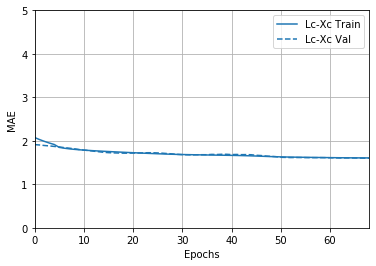

In [49]:
histories['Lc-Xc'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [50]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,val_labels1], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:17.2252,  mae:2.5029,  mse:17.2252,  val_loss:5.1434,  val_mae:1.8087,  val_mse:5.1434,  
.................................

Text(0, 0.5, 'MAE')

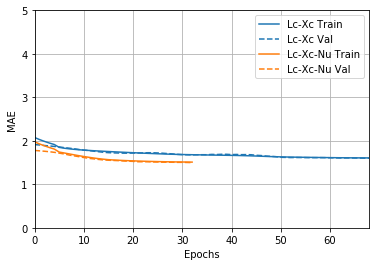

In [51]:
histories['Lc-xc-nu'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [52]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels2], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:12.0324,  mae:1.7399,  mse:12.0324,  val_loss:2.0376,  val_mae:1.0586,  val_mse:2.0376,  
...............

Text(0, 0.5, 'MAE')

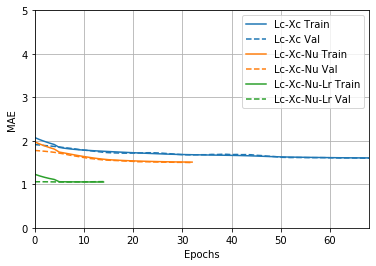

In [53]:
histories['Lc-xc-nu-Lr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [54]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels3], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:9.4460,  mae:1.6010,  mse:9.4460,  val_loss:2.1392,  val_mae:1.0901,  val_mse:2.1392,  
...................................................

Text(0, 0.5, 'MAE')

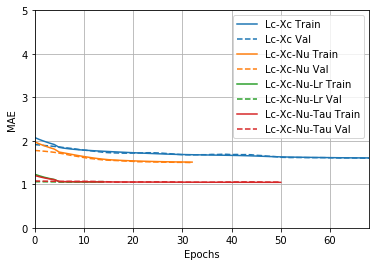

In [55]:
histories['Lc-xc-nu-tau'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [56]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

Text(0, 0.5, 'MAE')

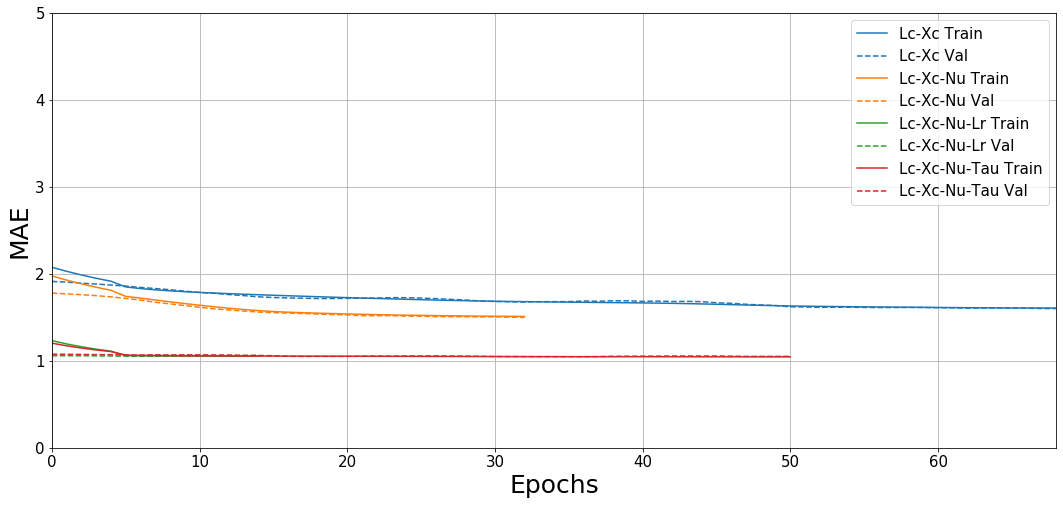

In [57]:
plotter.plot(histories, metric = "mae")
plt.ylim([0, 5])
plt.ylabel('MAE')

In [58]:
#plt.savefig("histories_MAE.png", bbox_inches='tight', dpi=600)

In [59]:
#plt.savefig("histories_MAE.pdf", bbox_inches='tight')

Text(0, 0.5, 'MSE of AU')

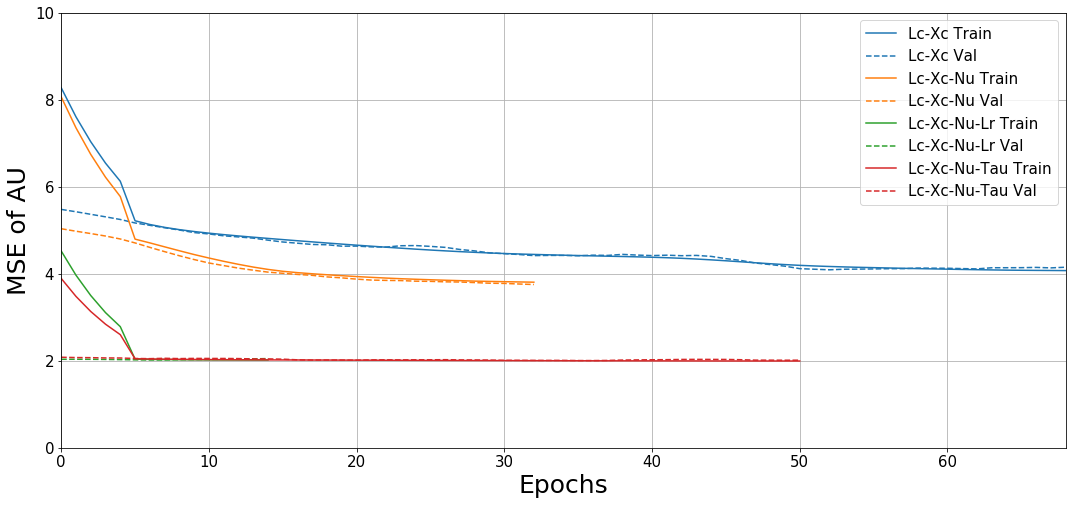

In [60]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 10])
plt.ylabel('MSE of AU')

In [61]:
model4 = build_model(len(normed_train_data4.keys()),activ,learn)

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_data=[normed_val_data4,val_labels4], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:2.7178,  mae:1.1885,  mse:2.7178,  val_loss:2.1828,  val_mae:1.1138,  val_mse:2.1828,  
.............

In [62]:
histories['xc-nu-tau'] = early_history4

# this uses rescaled labels and is should not be compared directly with the other time series
histories2 = {}
histories2['xc-nu-tau'] = early_history4

#plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
#plotter.plot(histories2, metric = "mae")
#plt.ylim([0, 5])
#plt.ylabel('MAE of AU')

In [63]:
#plotter.plot(histories, metric = "mse")
#plt.ylim([0, 5])
#plt.ylabel('MSE of AU')

In [64]:
model5 = build_model(len(normed_train_data5.keys()),activ,learn)

early_history5 = model5.fit(normed_train_data5, train_labels5, 
                    epochs=EPOCHS, validation_data=[normed_val_data5,val_labels5], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.2994,  mae:1.3063,  mse:3.2994,  val_loss:2.3766,  val_mae:1.1918,  val_mse:2.3766,  
..............................................

In [65]:
histories['xc-tau'] = early_history5

# this uses rescaled labels and is should not be compared directly with the other time series
histories3 = {}
histories3['xc-tau'] = early_history5

#plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
#plotter.plot(histories3, metric = "mae")
#plt.ylim([0, 5])
#plt.ylabel('MAE of AU')

In [66]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

114312/114312 - 2s - loss: 9.0775 - mae: 2.2868 - mse: 9.0775
Testing set for model 0, Mean Abs Error:    2.28683


In [67]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

114312/114312 - 2s - loss: 6.0200 - mae: 1.9287 - mse: 6.0200
Testing set for model 1, Mean Abs Error:    1.92869


In [68]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

114312/114312 - 2s - loss: 1.8538 - mae: 1.0191 - mse: 1.8538
Testing set for model 2, Mean Abs Error:    1.01911


In [69]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

114312/114312 - 2s - loss: 1.7914 - mae: 0.9957 - mse: 1.7914
Testing set for model 3, Mean Abs Error:    0.99569


In [70]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

114312/114312 - 2s - loss: 1.8953 - mae: 1.0401 - mse: 1.8953
Testing set for model 4, Mean Abs Error:    1.04014


In [71]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data5, test_labels5, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:10.5f}".format(mae5))

114312/114312 - 2s - loss: 2.0473 - mae: 1.1071 - mse: 2.0473
Testing set for model 5, Mean Abs Error:    1.10707


Note that models 4 and 5 with use a different target dataset, different labels. Hence, the metrics shown here are not comparable. This will be fixed in the next section.

# Make predictions

Finally, predict the fall velocity values using data in the testing set:

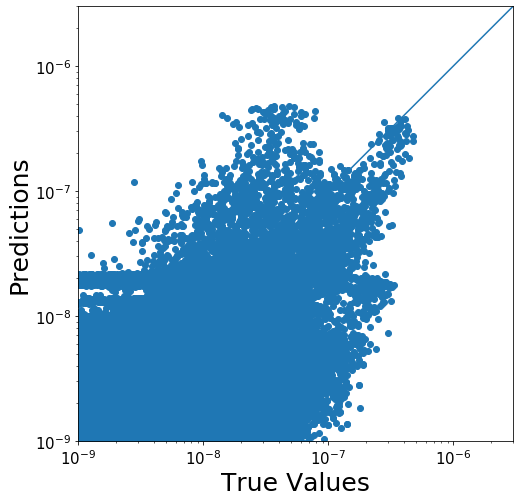

In [72]:
test_au0 = np.exp(test_labels0)
test_au1 = np.exp(test_labels1)
test_au2 = np.exp(test_labels2)
test_au3 = np.exp(test_labels3)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 1e-9, 3e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au1, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

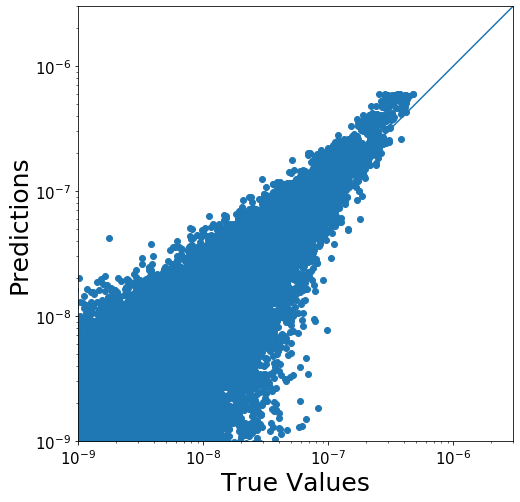

In [73]:
a = plt.axes(aspect='equal')
plt.scatter(test_au2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

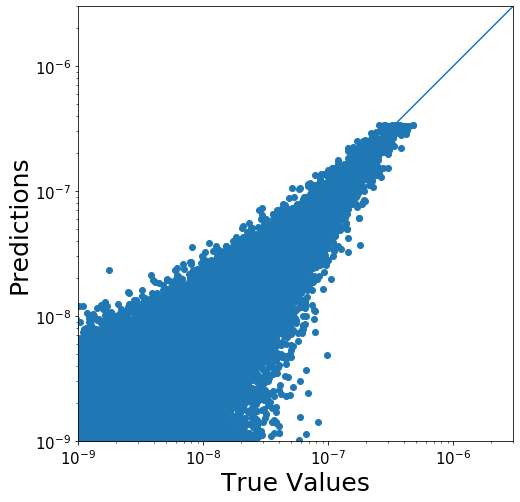

In [74]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

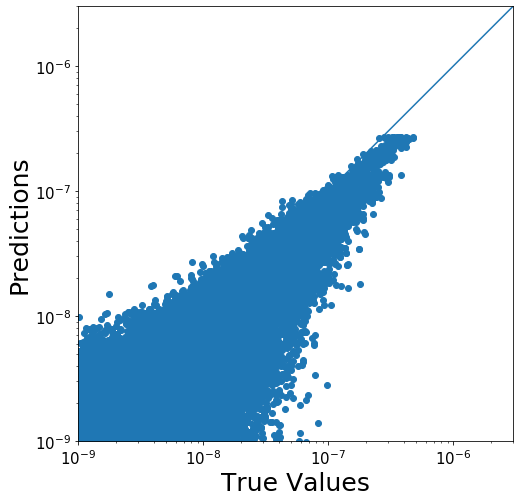

In [75]:
test_au4 = np.exp(test_labels4)

# re-scale this back to regular autoconversion
qc  = np.exp(np.array(test_dataset3.Lc))

test_predict4 = qc*qc * np.exp(model4.predict(normed_test_data4).flatten())
test_au4 = test_au4 * qc*qc

a = plt.axes(aspect='equal')
plt.scatter(test_au4, test_predict4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

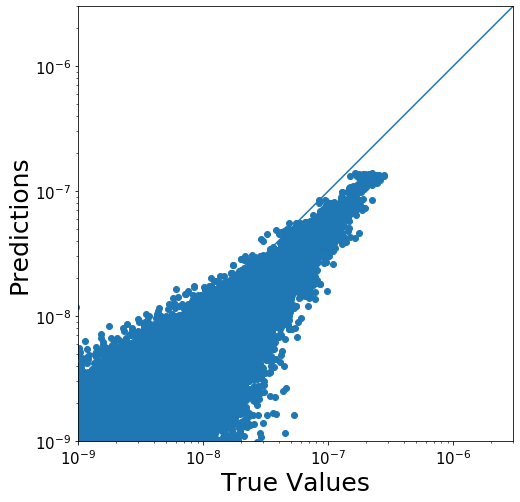

In [76]:
test_au5 = np.exp(test_labels5)

# re-scale this back to regular autoconversion
qc = np.exp(np.array(test_dataset3.Lc))
nu = np.exp(np.array(test_dataset3.nu))

scalingfactor = qc*qc * (nu+2.0)*(nu+4.0)/(nu+1.0)**2

test_predict5 = scalingfactor * np.exp(model5.predict(normed_test_data5).flatten())
test_au5 = test_au5 * scalingfactor

a = plt.axes(aspect='equal')
plt.scatter(test_au5, test_predict5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [77]:
test_dataset3.describe()

Lc             Xc            tau             nu
count  114312.000000  114312.000000  114312.000000  114312.000000
mean       -7.800608     -25.721569      -4.598324       1.998040
std         0.671941       0.491117       3.737306       1.107676
min       -10.008868     -26.690422     -18.069786       0.500000
25%        -8.147650     -26.123439      -7.034030       1.500000
50%        -7.723305     -25.815642      -3.786315       1.500000
75%        -7.270895     -25.339330      -1.344769       2.500000
max        -6.503471     -24.882586      -0.162521       3.500000

In [78]:
qc  = np.exp(np.array(test_dataset3.Lc))
xc  = np.exp(np.array(test_dataset3.Xc))
nue = np.array(test_dataset3.nu)

tau2 = np.exp(np.array(test_dataset3.tau))

## SB2001 autoconversion rate, original and re-trained on current data

In [79]:
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
xstar = 2.6e-10   # xstar in kg

au = kcc/(20*xstar) * (nue+2.0)*(nue+4.0)/(nue+1.0)**2 * qc**2 * xc**2

a1 = 600.
p1 = 0.68
taup = np.power(tau2,p1)
phi1 = a1 * taup * (1.0 - taup)**3

a2 = 954.
p2 = 0.773
taup = np.power(tau2,p2)
phi2 = a2 * taup * (1.0 - taup)**3

auSB1 = au * phi1
auSB2 = au * phi2


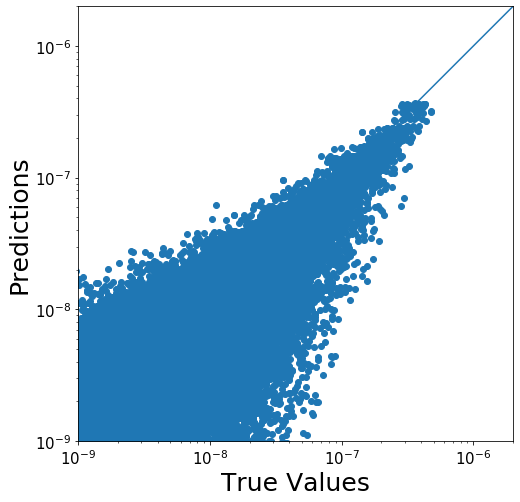

In [80]:
test_predict_sb = auSB2

amin, amax = 1e-9, 2e-6

a = plt.axes(aspect='equal')
plt.scatter(test_au3, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## KK2000 autoconversion

In [81]:

nc = qc/xc * 1e-6  # Nc in CGS

auKK = 1350. * np.power(qc,2.47) * np.power(nc,-1.79)

## Power law regression 

from notebook 'McSnow_autocon_powerlaws'

In [82]:
fac = 7.540743e+13 
a = 2.786325 
b = -1.620419 
c = -0.808443 

nc = qc/xc

# AU = fac * Lc**a * Nc**b * nu**c
auPwr = fac * np.power(qc,a) * np.power(nc,b) * np.power(nue+1,c)  

In [83]:
np.mean(auPwr)

5.307164e-09

In [84]:
np.mean(auKK)

5.8389036e-09

## Final statistics 

In [85]:
au0 = test_predict0
au1 = test_predict1
au2 = test_predict2
au3 = test_predict3
au4 = test_predict4
au5 = test_predict5

auTruth = test_au3

In [86]:
np.max(auTruth)

4.7286496851484117e-07

In [87]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [88]:
mae0 = mean_abs_error(au0,test_au0)
mae1 = mean_abs_error(au1,test_au1)
mae2 = mean_abs_error(au2,test_au2)
mae3 = mean_abs_error(au3,test_au3)
mae4 = mean_abs_error(au4,test_au4)
mae5 = mean_abs_error(au4,test_au5)

maeSB1 = mean_abs_error(auSB1,auTruth)
maeSB2 = mean_abs_error(auSB2,auTruth)
maeKK  = mean_abs_error(auKK,auTruth)
maePwr = mean_abs_error(auPwr,auTruth)

mse0 = mean_sqr_error(au0,test_au0)
mse1 = mean_sqr_error(au1,test_au1)
mse2 = mean_sqr_error(au2,test_au2)
mse3 = mean_sqr_error(au3,test_au3)
mse4 = mean_sqr_error(au4,test_au4)
mse5 = mean_sqr_error(au4,test_au5)

mseSB1 = mean_sqr_error(auSB1,auTruth)
mseSB2 = mean_sqr_error(auSB2,auTruth)
mseKK  = mean_sqr_error(auKK,auTruth)
msePwr = mean_sqr_error(auPwr,auTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, mae5, maeSB1, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mse5, mseSB1, mseSB2, mseKK, msePwr ]

In [89]:
mae

[1.3639477103311037e-08,
 5.768747701750954e-09,
 2.8340614299793288e-09,
 2.3886357336522224e-09,
 2.9556486147441774e-09,
 1.5634878947068387e-09,
 3.4573444107621754e-09,
 2.888854044869049e-09,
 6.426133403181211e-09,
 5.786807921737136e-09]

In [90]:
mse

[4.948610441063798e-08,
 1.8919113525041216e-08,
 9.456894945229223e-09,
 6.780902661977818e-09,
 9.389225807210202e-09,
 4.368029135202361e-09,
 1.1234737685001323e-08,
 8.100862314146286e-09,
 1.726945359270158e-08,
 1.6068718066152277e-08]

In [91]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('SB new')
labels.append('KK2000')
labels.append('Power')
labels

['Lc-Xc',
 'Lc-xc-nu',
 'Lc-xc-nu-Lr',
 'Lc-xc-nu-tau',
 'xc-nu-tau',
 'xc-tau',
 'SB2001',
 'SB new',
 'KK2000',
 'Power']

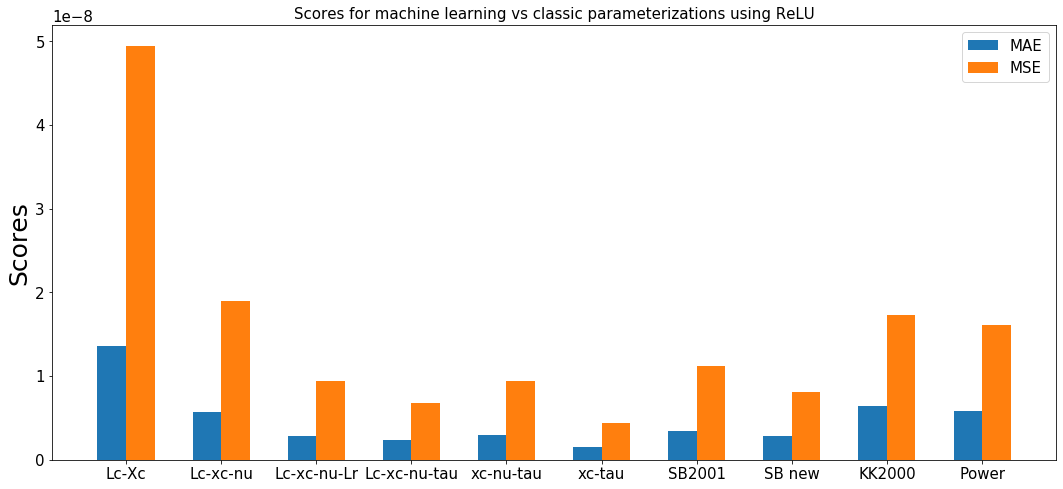

In [92]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs classic parameterizations using '+activ)
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(3e-7)
ax.legend()

#fig.tight_layout()

plt.show()

In [93]:
fig.savefig("autocon_barplot_"+activ+"_"+data+".png", bbox_inches='tight', dpi=600)

# Save models to file

In [94]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v7
    
model0.save('saved_model_v7/autocon_LcXc_v6_'+activ+'_'+DNNstring+'_'+data) 
model1.save('saved_model_v7/autocon_LcXcNu_v6_'+activ+'_'+DNNstring+'_'+data) 
model2.save('saved_model_v7/autocon_LcXcNuLr_v6_'+activ+'_'+DNNstring+'_'+data) 
model3.save('saved_model_v7/autocon_LcXcNuTau_v6_'+activ+'_'+DNNstring+'_'+data) 
model4.save('saved_model_v7/autoL2_XcNuTau_v6_'+activ+'_'+DNNstring+'_'+data) 
model5.save('saved_model_v7/autoL2nu_XcTau_v6_'+activ+'_'+DNNstring+'_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model_v7/autocon_LcXc_v6_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats1.to_pickle('saved_model_v7/autocon_LcXcNu_v6_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats2.to_pickle('saved_model_v7/autocon_LcXcNuLr_v6_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model_v7/autocon_LcXcNuTau_v6_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats4.to_pickle('saved_model_v7/autoL2_XcNuTau_v6_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats5.to_pickle('saved_model_v7/autoL2nu_XcTau_v6_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_v7/autocon_LcXc_v6_ReLU_16x16x16_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v7/autocon_LcXcNu_v6_ReLU_16x16x16_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v7/autocon_LcXcNuLr_v6_ReLU_16x16x16_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v7/autocon_LcXcNuTau_v6_ReLU_16x16x16_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v7/autoL2_XcNuTau_v6_ReLU_16x16x16_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v7/autoL2nu_XcTau_v6_ReLU_16x16x16_big_n5_z12/assets


# Model on gridded data to visualize dependencies

In [95]:

qc1d = np.linspace(0.1,2.0,50) * 1e-3
#tau1d = np.logspace(1e-6,1.0,51)
tau1d = np.linspace(0,1.0,50)
nu1d = np.linspace(0,4,6)
rc1d = np.linspace(11,15,10) * 1e-6
#nc1d = np.linspace(np.nanmin(Nc),np.nanmax(Nc),20)

tau1d[0] = 1e-6

qc3d, tau3d, nu3d, rc3d = np.meshgrid(qc1d, tau1d, nu1d, rc1d)

xc3d = 4./3. * 3.14 * 1e3 * rc3d**3

In [96]:
nc3d = qc3d/xc3d
qr3d = qc3d * (1.0/tau3d - 1.0)

In [97]:
gdata = pd.DataFrame(np.array( [ np.log(qc3d.ravel()), np.log(xc3d.ravel()), np.log(qr3d.ravel()), np.log(tau3d.ravel()), nu3d.ravel() ]))
gdata = gdata.T
gdata.columns = ['Lc','Xc','Lr','tau','nu'] 

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [98]:
gdata1 = gdata.copy()
gdata2 = gdata.copy()
gdata3 = gdata.copy()

In [99]:
gdata1 = gdata.drop(['Lr','tau'], axis=1)
gdata2 = gdata.drop("tau", axis=1)
gdata3 = gdata.drop("Lr", axis=1)

In [100]:
gdata3.head()

Lc         Xc        tau   nu
0 -9.21034 -25.913186 -13.815511  0.0
1 -9.21034 -25.794358 -13.815511  0.0
2 -9.21034 -25.680059 -13.815511  0.0
3 -9.21034 -25.569955 -13.815511  0.0
4 -9.21034 -25.463749 -13.815511  0.0

In [101]:
gdata3_stats = gdata3.describe()
gdata3_stats.transpose()

count       mean       std        min        25%        50%  \
Lc   150000.0  -7.070660  0.740840  -9.210340  -7.478143  -6.859136   
Xc   150000.0 -25.426613  0.296577 -25.913186 -25.680059 -25.412462   
tau  150000.0  -1.198979  2.001299 -13.815511  -1.406914  -0.693355   
nu   150000.0   2.000000  1.366265   0.000000   0.800000   2.000000   

           75%        max  
Lc   -6.479424  -6.214608  
Xc  -25.165984 -24.982721  
tau  -0.280902   0.000000  
nu    3.200000   4.000000

In [102]:
normed_gdata1 = norm(gdata1,train_stats1)
normed_gdata2 = norm(gdata2,train_stats2)
normed_gdata3 = norm(gdata3,train_stats3)

normed_gdata1_stats = normed_gdata1.describe()
normed_gdata1_stats.transpose()

count      mean       std       min       25%       50%       75%  \
Lc  150000.0  1.159367  0.944644 -1.568938  0.639785  1.429081  1.913250   
Xc  150000.0  0.582519  0.600691 -0.402991  0.069187  0.611181  1.110400   
nu  150000.0  0.019495  0.982968 -1.419418 -0.843852  0.019495  0.882843   

         max  
Lc  2.250917  
Xc  1.481583  
nu  1.458408

In [103]:
auto1 = model1.predict(normed_gdata1).flatten()
auto2 = model2.predict(normed_gdata2).flatten()
auto3 = model3.predict(normed_gdata3).flatten()


In [104]:
auto3d_model1 = np.exp(np.reshape(auto1,qc3d.shape))
auto3d_model2 = np.exp(np.reshape(auto2,qc3d.shape))
auto3d_model3 = np.exp(np.reshape(auto3,qc3d.shape))

In [105]:
qc3d.shape

(50, 50, 6, 10)

In [106]:
au = kcc/(20*xstar) * (nu3d+2.0)*(nu3d+4.0)/(nu3d+1.0)**2 * qc3d**2 * xc3d**2
taup = np.power(tau3d,p2)
phi2 = a2 * taup * (1.0 - taup)**3

auSB = au * phi2

In [107]:
np.nanmean(auSB)

3.7857145093017184e-08

In [108]:
np.nanmean(auto3d_model3)

9.708906e-08

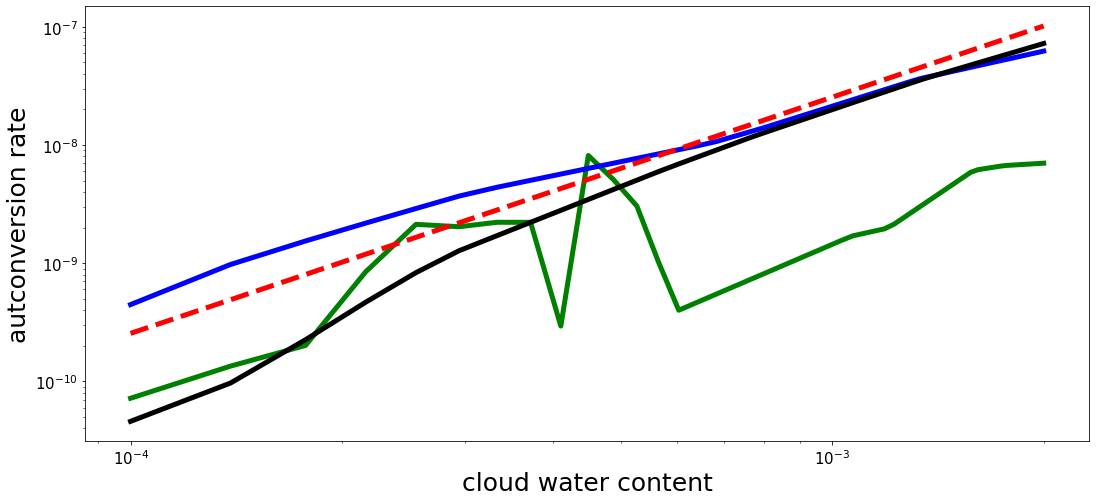

In [109]:
iqr = 3
inu = 2
inc = 3

plt.plot(qc3d[iqr,:,inu,inc], auto3d_model1[iqr,:,inu,inc], 'g-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auto3d_model2[iqr,:,inu,inc], 'b-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auto3d_model3[iqr,:,inu,inc], 'k-', linewidth=5)
plt.plot(qc3d[iqr,:,inu,inc], auSB[iqr,:,inu,inc], 'r--', linewidth=5)

plt.xlabel('cloud water content')
plt.ylabel('autconversion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

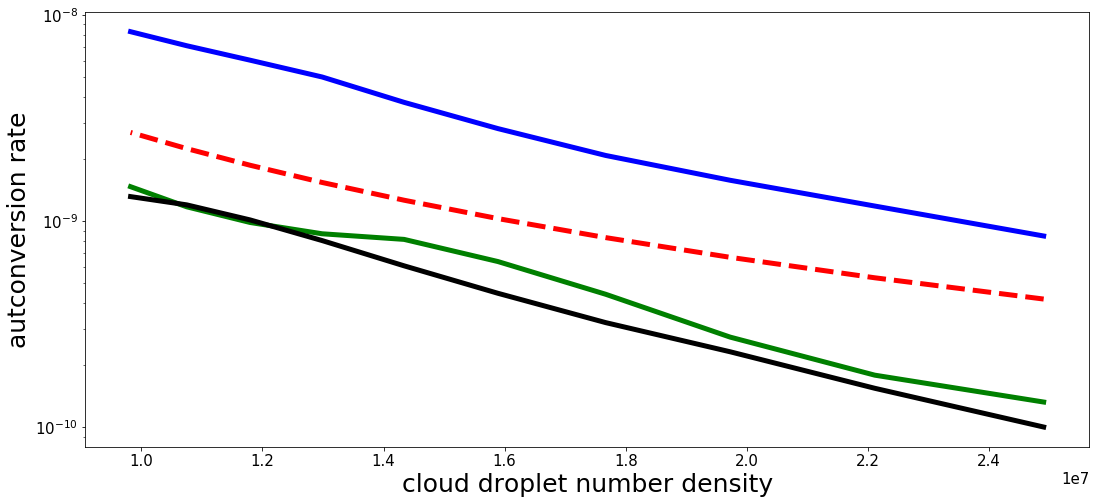

In [110]:
iqc = 1
iqr = 5
inu = 1

plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model1[iqr,iqc,inu,:], 'g-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model2[iqr,iqc,inu,:], 'b-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auto3d_model3[iqr,iqc,inu,:], 'k-', linewidth=5)
plt.plot(nc3d[iqr,iqc,inu,:], auSB[iqr,iqc,inu,:], 'r--', linewidth=5)

plt.xlabel('cloud droplet number density')
plt.ylabel('autconversion rate')

plt.yscale('log')
#plt.xscale('log')
plt.show()

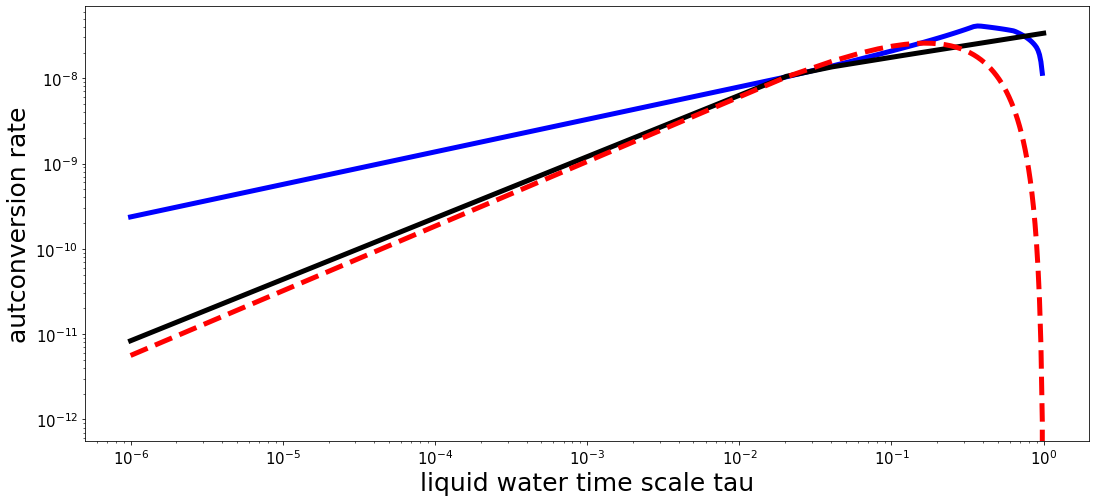

In [111]:
iqc = 20
inu = 2
inc = 3

#plt.plot(tau3d[:,iqc,inu,inc], auto3d_model2[:,iqc,inu,inc], 'g-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auto3d_model2[:,iqc,inu,inc], 'b-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auto3d_model3[:,iqc,inu,inc], 'k-', linewidth=5)
plt.plot(tau3d[:,iqc,inu,inc], auSB[:,iqc,inu,inc], 'r--', linewidth=5)

plt.xlabel('liquid water time scale tau')
plt.ylabel('autconversion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

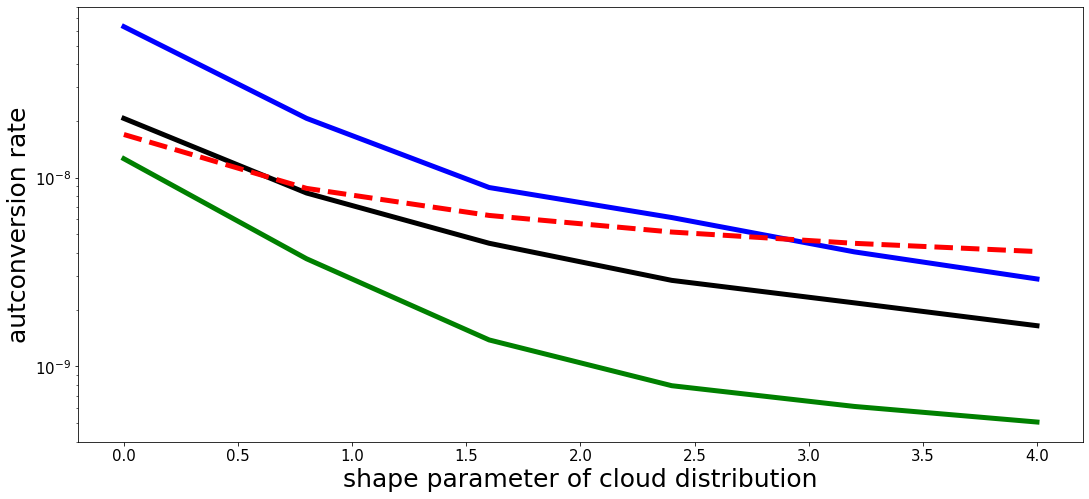

In [112]:
iqr = 10
iqc = 10
inc = 2

plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model1[iqr,iqc,:,inc], 'g-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model2[iqr,iqc,:,inc], 'b-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auto3d_model3[iqr,iqc,:,inc], 'k-', linewidth=5)
plt.plot(nu3d[iqr,iqc,:,inc], auSB[iqr,iqc,:,inc], 'r--', linewidth=5)

plt.xlabel('shape parameter of cloud distribution')
plt.ylabel('autconversion rate')

plt.yscale('log')
#plt.xscale('log')
plt.show()

In [113]:
def autocon(qc,xc,qr,nu):
    tau  = qr/(qc+qr)
    data = pd.DataFrame(np.array( [ np.log(qc.ravel()), np.log(xc.ravel()), np.log(tau.ravel()), nu.ravel() ]))
    data = data.T
    data.columns = [ 'Lc','Xc','tau','nu' ] 
    normed_data = norm(data,train_stats3)
    auto = model3.predict(normed_data).flatten()

    return np.exp(auto)

In [114]:

qc = np.array(1e-3)
xc = np.array(7.2e-12)
qr = np.array(1e-10)
nu = np.array(0.0)
print(autocon(qc,xc,qr,nu))

[3.4248568e-12]
